In [1]:
import sys, os
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.config import PROCESSED_RETURNS_PARQUET


In [3]:
rets = pd.read_parquet(PROCESSED_RETURNS_PARQUET).dropna(how="any")
assets = rets.columns.tolist()

# Baselines
w_base = pd.read_csv("data/processed/baseline_weights.csv", index_col=0)
w_equal = w_base.loc[assets, "Equal Weight"].values
w_mvo   = w_base.loc[assets, "Mean-Variance"].values

# Risk Parity
rp_df = pd.read_csv("data/processed/risk_parity_weights_and_risk.csv", index_col=0)
w_rp = rp_df.loc[assets, "weight"].values

PORTS = {
    "Equal Weight": w_equal,
    "Mean-Variance": w_mvo,
    "Risk Parity": w_rp
}

def port_returns(w):
    return rets @ w


In [4]:
def rolling_ann_vol(log_returns: pd.Series, window: int = 63) -> pd.Series:
    return log_returns.rolling(window).std(ddof=1) * np.sqrt(252)

def rolling_var(log_returns: pd.Series, window: int = 252, alpha: float = 0.05) -> pd.Series:
    # Historical VaR (positive number representing loss threshold)
    return -log_returns.rolling(window).quantile(alpha)

def rolling_cvar(log_returns: pd.Series, window: int = 252, alpha: float = 0.05) -> pd.Series:
    # Historical CVaR: average of tail losses beyond VaR
    def _cvar(x):
        q = np.quantile(x, alpha)
        tail = x[x <= q]
        return -tail.mean() if len(tail) > 0 else np.nan
    return log_returns.rolling(window).apply(_cvar, raw=False)

def drawdown(log_returns: pd.Series) -> pd.Series:
    eq = np.exp(log_returns.cumsum())
    peak = eq.cummax()
    return eq / peak - 1.0

def rolling_corr(series_a: pd.Series, series_b: pd.Series, window: int = 63) -> pd.Series:
    return series_a.rolling(window).corr(series_b)


In [5]:
port_series = {name: port_returns(w) for name, w in PORTS.items()}
port_df = pd.DataFrame(port_series)

port_df.head()


,Equal Weight,Mean-Variance,Risk Parity
Date,,,
2014-01-03,-0.000419,0.000786,-0.000419
2014-01-06,-0.000304,0.001679,-0.000304
2014-01-07,0.005062,0.001191,0.005062
2014-01-08,-0.001370,-0.003597,-0.001370
2014-01-09,-0.001217,0.002044,-0.001217


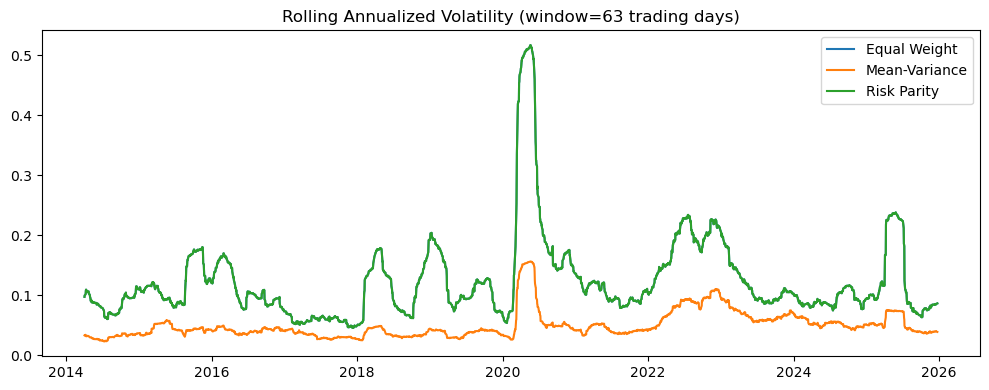

In [6]:
VOL_WINDOW = 63  # ~3 months

plt.figure(figsize=(10,4))
for name in port_df.columns:
    plt.plot(rolling_ann_vol(port_df[name], VOL_WINDOW), label=name)
plt.title(f"Rolling Annualized Volatility (window={VOL_WINDOW} trading days)")
plt.legend()
plt.tight_layout()
plt.show()


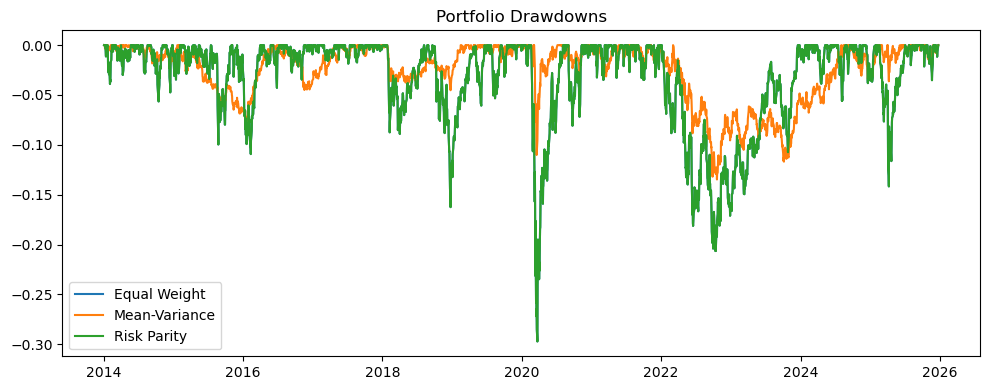

In [7]:
plt.figure(figsize=(10,4))
for name in port_df.columns:
    plt.plot(drawdown(port_df[name]), label=name)
plt.title("Portfolio Drawdowns")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
RISK_WINDOW = 252
ALPHA = 0.05  # 95% VaR

risk_out = {}

for name in port_df.columns:
    r = port_df[name]
    var = rolling_var(r, window=RISK_WINDOW, alpha=ALPHA)
    cvar = rolling_cvar(r, window=RISK_WINDOW, alpha=ALPHA)
    breaches = (r < -var).astype(int)  # 1 if loss worse than VaR
    risk_out[name] = pd.DataFrame({
        "ret": r,
        "VaR": var,
        "CVaR": cvar,
        "breach": breaches
    })

risk_out["Risk Parity"].tail()


,ret,VaR,CVaR,breach
Date,,,,
2025-12-17,-0.003980,0.011895,0.020689,0
2025-12-18,0.003173,0.011895,0.020689,0
2025-12-19,0.002438,0.011895,0.020689,0
2025-12-22,0.004997,0.011612,0.019701,0
2025-12-23,0.002478,0.011612,0.019701,0


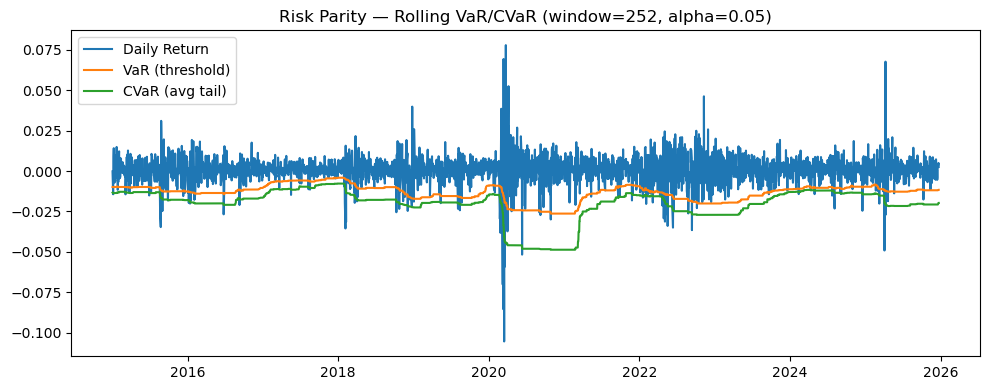

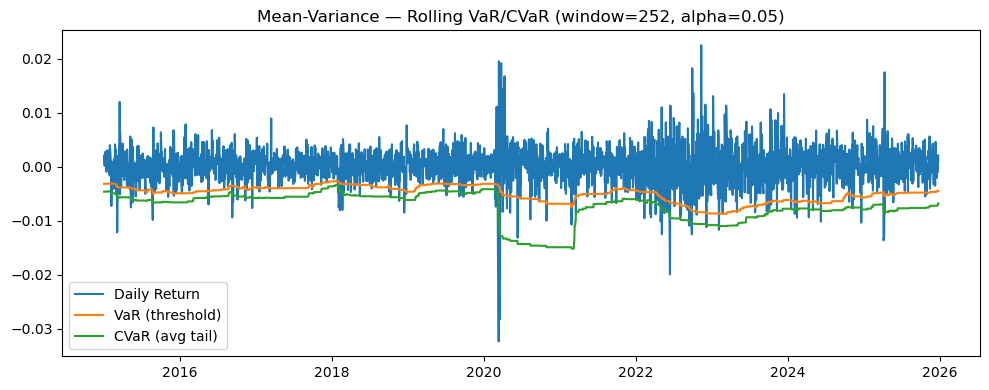

In [9]:
def plot_var_cvar(name: str):
    df = risk_out[name].dropna()
    plt.figure(figsize=(10,4))
    plt.plot(df.index, df["ret"], label="Daily Return")
    plt.plot(df.index, -df["VaR"], label="VaR (threshold)")
    plt.plot(df.index, -df["CVaR"], label="CVaR (avg tail)")
    plt.title(f"{name} — Rolling VaR/CVaR (window={RISK_WINDOW}, alpha={ALPHA})")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_var_cvar("Risk Parity")
plot_var_cvar("Mean-Variance")


In [10]:
breach_rows = []
for name, df in risk_out.items():
    dd = df.dropna()
    breach_rate = dd["breach"].mean()
    breach_rows.append({
        "portfolio": name,
        "window": RISK_WINDOW,
        "alpha": ALPHA,
        "expected_breach_rate": ALPHA,
        "observed_breach_rate": float(breach_rate),
        "num_breaches": int(dd["breach"].sum()),
        "num_obs": int(len(dd)),
    })

breach_summary = pd.DataFrame(breach_rows).sort_values("observed_breach_rate", ascending=False)
breach_summary


,portfolio,window,alpha,expected_breach_rate,observed_breach_rate,num_breaches,num_obs
1,Mean-Variance,252,0.05,0.05,0.053966,149,2761
0,Equal Weight,252,0.05,0.05,0.052879,146,2761
2,Risk Parity,252,0.05,0.05,0.052879,146,2761


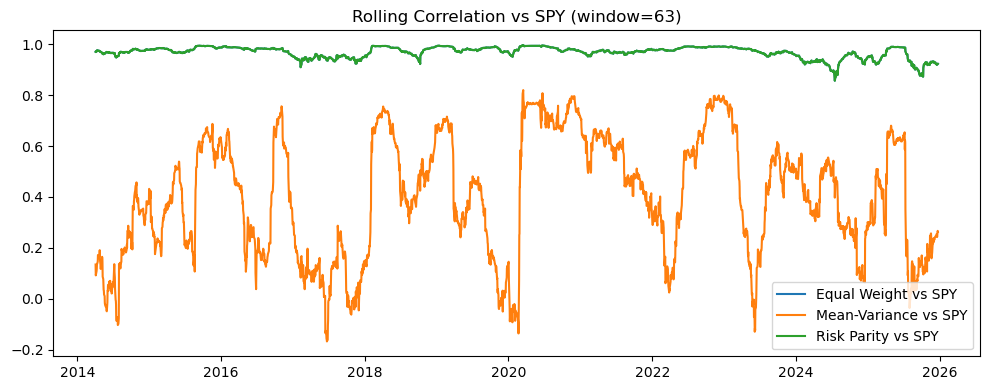

In [11]:
if "SPY" in rets.columns:
    spy = rets["SPY"]
    CORR_WINDOW = 63

    plt.figure(figsize=(10,4))
    for name in port_df.columns:
        c = rolling_corr(port_df[name], spy, CORR_WINDOW)
        plt.plot(c, label=f"{name} vs SPY")
    plt.title(f"Rolling Correlation vs SPY (window={CORR_WINDOW})")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("SPY not in universe — skipping correlation-vs-SPY monitor.")


In [12]:
alerts = []

for name in port_df.columns:
    r = port_df[name]
    vol = rolling_ann_vol(r, VOL_WINDOW)
    dd = drawdown(r)

    latest_date = r.index[-1]
    latest_vol = float(vol.iloc[-1])
    latest_dd = float(dd.iloc[-1])

    # Simple thresholds (tune later)
    alert_vol = latest_vol > 0.25
    alert_dd  = latest_dd < -0.15

    # VaR breach in last 20 days
    recent = risk_out[name].dropna().tail(20)
    recent_breaches = int(recent["breach"].sum())

    alerts.append({
        "date": latest_date.date(),
        "portfolio": name,
        "rolling_vol": latest_vol,
        "current_drawdown": latest_dd,
        "VaR_breaches_last_20d": recent_breaches,
        "ALERT_vol_gt_25%": alert_vol,
        "ALERT_drawdown_lt_-15%": alert_dd
    })

alerts_df = pd.DataFrame(alerts)
alerts_df


,date,portfolio,rolling_vol,current_drawdown,VaR_breaches_last_20d,ALERT_vol_gt_25%,ALERT_drawdown_lt_-15%
0,2025-12-23,Equal Weight,0.086628,0.0,0,False,False
1,2025-12-23,Mean-Variance,0.039170,0.0,0,False,False
2,2025-12-23,Risk Parity,0.086628,0.0,0,False,False


In [13]:
breach_summary.to_csv("data/processed/var_breach_summary.csv", index=False)
alerts_df.to_csv("data/processed/risk_monitor_alerts.csv", index=False)

# Save time series (optional but useful)
for name, df in risk_out.items():
    df.to_parquet(f"data/processed/risk_monitor_{name.replace(' ','_').lower()}.parquet")

print("Saved monitoring outputs to data/processed/")


Saved monitoring outputs to data/processed/
